# Load the libraries & data

In [9]:

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import math
import scipy
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from scipy.sparse import csr_matrix
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import seaborn as sns
from ipywidgets import interact
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.decomposition import TruncatedSVD
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.base import TransformerMixin, ClassifierMixin
from sklearn.utils import resample as sk_resample
from datasets import load_dataset
import statsmodels.api as sm
import jax
import pickle
import jax.numpy as jnp


In [ ]:
try:
    jax_init
except NameError:
    jax.distributed.initialize()
    jax_init = True

In [11]:

try:
    with open("dataset.pickle", "rb") as f:
        dataset = pickle.load(f)
except FileNotFoundError:
    dataset = load_dataset("McAuley-Lab/Amazon-Reviews-2023", "raw_review_Handmade_Products", trust_remote_code=True)
    with open("dataset.pickle", "wb") as f:
        pickle.dump(dataset, f)

data = pd.DataFrame(dataset["full"])[["text", "rating"]]
train_x, test_x, train_y, test_y = train_test_split(data["text"], data["rating"], test_size=0.2)

# Preprocess the texts

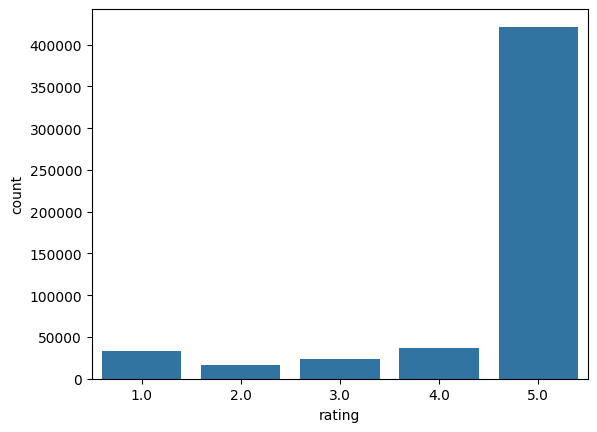

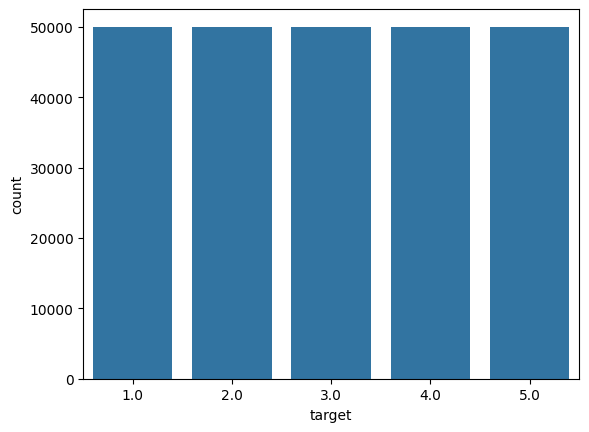

In [12]:
def visualize_class_imbalance(y):
    ch = sns.barplot(y.value_counts())
    return ch

def resample(x, y, target_samples):
    df = pd.concat([x, y], axis=1)
    df.columns = ['feature', 'target']


    resampled_dfs = []
    for category in df['target'].unique():
        category_df = df[df['target'] == category]
        n_samples = len(category_df)
        if n_samples < target_samples:
            # Upsample the minority class
            n_to_upsample = target_samples - n_samples
            upsampled = sk_resample(category_df,
                                     replace=True,
                                     n_samples=target_samples,
                                     random_state=42)
            resampled_dfs.append(upsampled)
        else:
            # If the class already has the maximum number of samples, keep it as is
            resampled_dfs.append(category_df.sample(target_samples))

    df_resampled = pd.concat(resampled_dfs)
    x_resampled = df_resampled['feature']
    y_resampled = df_resampled['target']
    return x_resampled, y_resampled
    
visualize_class_imbalance(train_y)
plt.show()
train_x_resampled, train_y_resampled = resample(train_x, train_y, 50000)
visualize_class_imbalance(train_y_resampled)
plt.show()

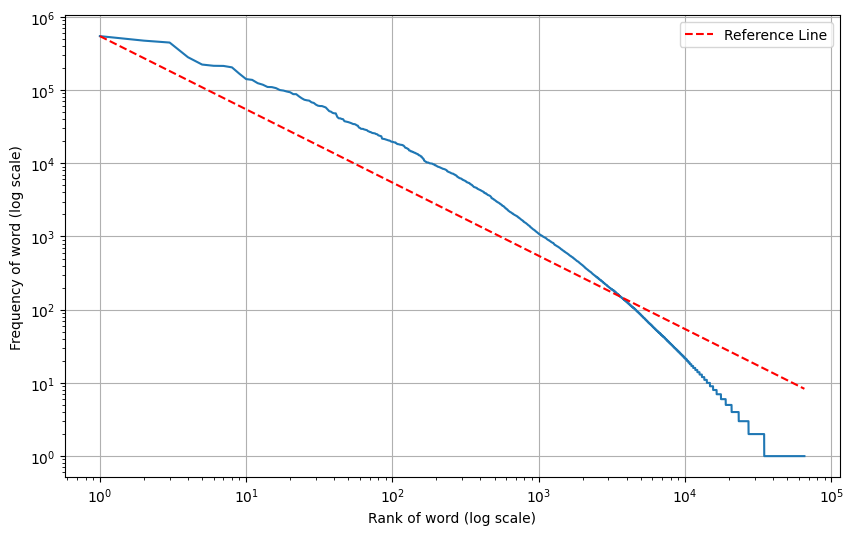

In [13]:
# Initialize CountVectorizer
vectorizer = CountVectorizer()

# Fit and transform the training data
X_train_counts = vectorizer.fit_transform(train_x)

# Sum word counts across all documents
word_counts = np.asarray(X_train_counts.sum(axis=0)).flatten()

# Sort word counts in descending order
sorted_word_counts = np.sort(word_counts)[::-1]

# Create ranks (1, 2, 3, ...)
ranks = np.arange(1, len(sorted_word_counts) + 1)

# Create the log-log plot
plt.figure(figsize=(10, 6))
plt.loglog(ranks, sorted_word_counts)
plt.xlabel("Rank of word (log scale)")
plt.ylabel("Frequency of word (log scale)")
plt.grid(True)

# Calculate a reference line based on Zipf's law (frequency ~ C/rank)
# We can set C = frequency of the most frequent word
zipf_line = sorted_word_counts[0] / ranks

# Plot the reference line
plt.loglog(ranks, zipf_line, label="Reference Line", linestyle='--', color='red')
plt.legend()
plt.show()



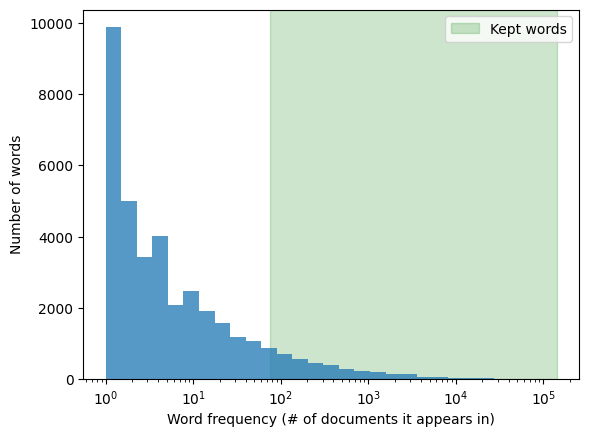

Keeping words with 76 (0.9 quantile) < frequency < 141436 (1.0 quantile)
i.e. keeping 0.10027703840512793 = 3692 feature dimensions


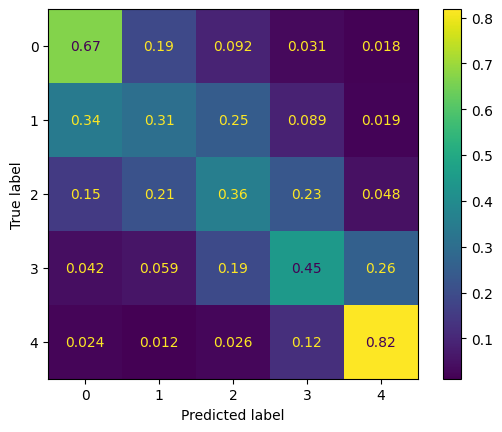

Accuracy: 0.7472841839000851


In [14]:

class RemovePercentileWordsTransformer(TransformerMixin):
    def __init__(self, min_percentile, max_percentile):
        self.min_percentile = min_percentile
        self.max_percentile = max_percentile
        pass

    def fit(self, X, y=None, **fit_params):
        frequencies = np.asarray((X > 0).sum(axis=0)).reshape((-1,))
        axs = plt.axes()
        max_occurances = int(np.percentile(frequencies, self.max_percentile*100.0))
        min_occurances = int(np.percentile(frequencies, self.min_percentile*100.0))
        axs.axvspan(min_occurances, max_occurances, ymin=0, ymax=1, color='green', alpha=0.2, label='Kept words')
        
        ax = sns.histplot(frequencies, bins=np.logspace(np.log10(frequencies.min()), np.log10(frequencies.max()), 30))
        ax.set_xscale("log")
        ax.set_xlabel("Word frequency (# of documents it appears in)")
        ax.set_ylabel("Number of words")
        
        plt.legend()
        plt.show()

        print(f"Keeping words with {min_occurances} ({self.min_percentile} quantile) < frequency < {max_occurances} ({self.max_percentile} quantile)", )
        
        self.keep_columns = np.logical_and(frequencies >= min_occurances, frequencies <= max_occurances)
        
        print(f"i.e. keeping {self.keep_columns.sum() / X.shape[1]} = {self.keep_columns.sum()} feature dimensions")
        return self

    def transform(self, X, y=None, **fit_params):
        cut_X = X[:, self.keep_columns]
        return cut_X
    
class StatsModelsLR(ClassifierMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y):
        print("Fitting")
        self.model = sm.Logit(y, X)
        self.res = self.model.fit(method="lbfgs")
        print(self.res)

    def predict(self, X):
        return self.model.predict(X)
    
pipeline = Pipeline([
    ("tf", CountVectorizer()),
    ("remove_percentile_words", RemovePercentileWordsTransformer(0.90, 1.0)), # we should tweak this
    ("classification", LogisticRegression(max_iter=1000))
])

pipeline.fit(train_x_resampled, train_y_resampled)

pred_y = pipeline.predict(test_x)
cm = confusion_matrix(test_y, pred_y, normalize="true")
cmd = ConfusionMatrixDisplay(cm)
cmd.plot()

plt.show()
print(f"Accuracy: {(pred_y == test_y).mean()}")

In [ ]:
import jax.numpy as jnp
def word_covariances(tf_mat: np.ndarray):
    n, d = tf_mat.shape
    mean_freq = tf_mat.mean(axis=0).A1
    XtX = tf_mat.T @ tf_mat
    mean_outer = jnp.outer(mean_freq, mean_freq) * n

    # Using Cov(X) = (X'X - x_bar x_bar' * n)/(n-1)
    cov_uncorrected = jnp.subtract(XtX.toarray(), mean_outer).astype("float32")
    cov = jnp.divide(cov_uncorrected, n-1)
    return cov


try:
    word_cov
except NameError:
    try:
        
        with open("word_cov.pickle", "rb") as f:
            print("Loading from disk")
            word_cov = pickle.load(f)
        print("Loaded from disk")
    except FileNotFoundError:
        print("Calculating")
        word_cov = word_covariances(pipeline.named_steps["tf"].transform(train_x_resampled))
        
        with open("word_cov.pickle", "wb") as f:
            pickle.dump(word_cov, f)
        print("Calculated")

word_var = jnp.diag(word_cov)

word_cor = jnp.diag(word_var ** -0.5) @ word_cov @ jnp.diag(word_var ** -0.5)

Loading from disk
Calculating
Calculated


: 

In [ ]:
word_cor[pipeline.named_steps["tf"].vocabulary_["good"], pipeline.named_steps["tf"].vocabulary_["bad"]]

In [ ]:
# Recalculate the term-frequency matrix used for word_cor
tf_mat = pipeline.named_steps["tf"].transform(train_x_resampled)
# Calculate document frequency for each word (number of documents it appears in)





NameError: name 'pipeline' is not defined

In [33]:
tf: CountVectorizer = pipeline.named_steps["tf"]
# Create inverse vocabulary mapping (index -> word)
inv_vocabulary = {v: k for k, v in tf.vocabulary_.items()}

# Get the indices from word_pairs
idx1 = word_pairs[0]
idx2 = word_pairs[1]

# Find the corresponding words
print("Top 10 word pairs by covariance:")
for i in range(len(idx1)):
    word1 = inv_vocabulary.get(int(idx1[i]), "N/A")
    word2 = inv_vocabulary.get(int(idx2[i]), "N/A")
    print(f"({word1}, {word2}) - Covariance: {values[i]:.4f}")



Top 10 word pairs by covariance:
(11x14, sending) - Covariance: 1.0000
(12, according) - Covariance: 1.0000
(12, decorating) - Covariance: 1.0000
(12, ribbon) - Covariance: 1.0000
(123, 4mm) - Covariance: 1.0000
(123, pounds) - Covariance: 1.0000
(123, studs) - Covariance: 1.0000
(13, 21) - Covariance: 1.0000
(13, attest) - Covariance: 1.0000
(13, caught) - Covariance: 1.0000
(13, cord) - Covariance: 1.0000
(13, db1f7f51a1c731870846e43261d55445) - Covariance: 1.0000
(13, depending) - Covariance: 1.0000
(13, elasticized) - Covariance: 1.0000
(13, fate) - Covariance: 1.0000
(13, gotta) - Covariance: 1.0000
(13, heavier) - Covariance: 1.0000
(13, lab) - Covariance: 1.0000
(13, labradorite) - Covariance: 1.0000
(13, rare) - Covariance: 1.0000
(13, ruin) - Covariance: 1.0000
(13, stretchy) - Covariance: 1.0000
(13, tempt) - Covariance: 1.0000
(13, tones) - Covariance: 1.0000
(13, tugged) - Covariance: 1.0000
(13, viewing) - Covariance: 1.0000
(13, visible) - Covariance: 1.0000
(16x20, dream

In [ ]:
def get_parameter_intervals(model: LinearRegression):
    model.coef_ # (n, d)

#np.nanmin(word_cov)
word_cov.shape
jnp.nanmin(word_cov)
jnp.nanmax(word_cov)


In [14]:
import pickle
with open("word_cov.pickle", "wb") as f:
    pickle.dump(np.array(word_cov), f)

In [ ]:

jnp.nanmin(word_cov)

Loading from disk
Loaded from disk


KeyboardInterrupt: 

In [19]:
cv = CountVectorizer()
word_counts = cv.fit_transform(train_x).sum(axis=0).reshape((-1, ))

In [20]:
percentile_words = np.array(np.argsort(word_counts)[:, np.linspace(word_counts.shape[1]/2, word_counts.shape[1]-1, 49).astype("int")]).reshape((-1, ))
print()
voc_inv = dict(zip(cv.vocabulary_.values(), cv.vocabulary_.keys()))
percentiles = np.linspace(51, 100, 49)
words = []
counts = []
for p in percentile_words:
    words.append(voc_inv[int(p)])
    counts.append(word_counts[0, p])
    
print(words)
word_percentiles = pd.DataFrame({'percentile': percentiles, 'word': words, "count": counts})
word_percentiles["percentile"] = np.round(word_percentiles["percentile"])
word_percentiles.to_csv("word_percentiles.csv", index=False)


['brink', 'pocketable', 'marlinspike', 'soundbar', 'silpada', 'topmost', 'atones', 'fanstastic', 'asg', '2month', 'sevice', 'wasp', 'dpt', 'costal', 'drs', 'angus', 'julius', 'knotty', 'lingered', 'mjlulu', 'matcha', 'ami', 'pleasurable', 'serotonin', 'salute', 'noone', 'cloak', 'mot', 'aparte', 'paranoid', '09', 'groovy', 'component', 'unsurpassed', 'jute', 'deter', 'tender', 'lounge', 'motto', 'grabbing', 'essence', 'continues', 'grandfather', 'serious', 'situation', 'garbage', 'pearls', 'arrive', 'the']


TimeoutError: [Errno 60] Operation timed out: 'word_percentiles.csv'

In [ ]:
def get_classification_report(pred_y, test_y):
    report = pd.DataFrame(classification_report(pred_y, test_y, output_dict=True))

    # Remove the accuracy column from the report since that formats badly
    return report.drop(columns=["accuracy"])

get_classification_report(pred_y, test_y)

,1.0,2.0,3.0,4.0,5.0,macro avg,weighted avg
precision,0.696322,0.253504,0.313518,0.411309,0.799249,0.494781,0.686977
recall,0.380488,0.189316,0.243194,0.218198,0.963315,0.398902,0.727696
f1-score,0.492087,0.216758,0.273914,0.285133,0.873646,0.428308,0.692799
support,15078.000000,5541.000000,7677.000000,17035.000000,87502.000000,132833.000000,132833.000000
